In [16]:
import requests,json, pandas as pd,matplotlib.pyplot as plt



#def main():
    
    #force_nh=choose_force_neighborhood()
    
    #coordinates=neighborhood_boundaries(force_nh)
    
    #js1,js2,js3,js4,js5,js6,ds1,ds2,ds3,ds4,ds5,ds6=monthly_crime(coordinates)
    
    #first3,second3=json_to_list(js1,js2,js3,js4,js5,js6)
    
    #full_dataframe=get_crime_rates(ds1,ds2,ds3,ds4,ds5,ds6)
    
    #crime_rates_graph(full_dataframe)
    
   # user_search=search_input()
    
    #first3_df=data_search(first3, user_search)
    
    #second3_df=data_search(second3, user_search )
    
    #analytics_graph(first3_df)
    
    #analytics_graph(second3_df)

In [17]:
def choose_force_neighborhood():
    
    '''This function lets the user enter the name of a police force. 
    It returns all the neighborhods that fall within 
    the jurisdiction of said police force.'''
    
    #have the user choose a police force 
    user_force=str(input('Enter a police force name to get back their neighbourhoods: '))
    
    #form the url for the API call 
    force1='/neighbourhoods'
    force2="https://data.police.uk/api/"+user_force+force1
   
     #call the API to get Sussex police neighborhoods 
    resp_hoods=requests.get(force2)
    
    #print server response code 
    print(resp_hoods)

    #decode response as text/data
    if int(resp_hoods.status_code)==200:
        print(resp_hoods.text)
        hoods=json.loads(resp_hoods.text)
    
    #have the user choose a neighborhood 
    user_hood=str(input('Enter a neighbhourhood from the list: '))
    
    #create empty string to hold the string 
    hood_id=''
    
    #loop through the reponse json object and test to match the user input and pull out 
    #the corresponding ID to put into the API call 
    for item in hoods:
        if item['name']in user_hood:
            hood_id+=item['id']
    #print(type(hood_id))
    
    #concatenate the strings to form the url to pass to the next function 
    force_hood=user_force+'/'+hood_id+'/boundary'
    #print(force_hood)
    #print(type(force_hood))
    return force_hood

In [18]:
def neighborhood_boundaries(force_hood):
    
    '''This function lets the user enter the name of a returned neighborhood, which
    has a unquie identifier. This idnetifier is put into a url and calls the API.
    
    For example, if the user enters 'East Brighton', its code-CE2NH1- is inserted into a url.
    The request returns latitude and longitude coordinates for said neighborhood. '''
    
    
    #pass in the unique identifier for the chosen neighborhood and insert into url 
    url1=force_hood
    url2="https://data.police.uk/api/"+url1
    
  
    #call API to get latitude and longitude coordinates for the neighborhood
    resp_bound=requests.get(url2)
    
    #print reponse code 
    print(resp_bound)
    
    #decode repsonse as text 
    if int(resp_bound.status_code)==200:
        #print('East Brighton: ',resp_bound.text)
        
        #turn response into json object
        coordinates=json.loads(resp_bound.text)
        
        return coordinates

In [19]:
def user_date_input():
    
    '''This function returns the user's chosen date so it can be passed to multiple functions
    to avoid redundancy yet maintain consistent dates on the data.'''
    
    date_search=input('Enter a date for which to get a crime report. Use format: YYYY-MM: ')
    
    return date_search 

In [20]:
def API_call(coordinates, date_search):
    
    '''This function lets the user enter a date and calls the API to return
    street crime data for that month. The results are written to a json file.'''  
    
    #get user's chosen date 
   # poly_string_date=input('Enter a date for which to get a crime report. Use format: YYYY-MM: ')
    poly_string_date=date_search 
    
    #loop through coordinates, putting lat. and long. values into a list 
    index=0
    poly_list=[]
    for item in coordinates:
        poly=(coordinates[index]['latitude'],coordinates[index]['longitude'])
        index+=1
        poly_list.append(poly)
    

    #flatten list of tuples (poly_list) into a single list of all values 
    single_list=([x for item in poly_list for x in item])
    
    #add colon to list for API url requirements 
    i=2
    while i<len(single_list):
        single_list.insert(i,':')
        i+=3
    
    #add comma to list for API url requirements 
    c=1
    while c<len(single_list):
        single_list.insert(c,',')
        c+=4
    
    #convert the list of coordinates into a string to function in a url 
    poly_string=""
    single_list_index=0
    for item in single_list:
        poly_string+=single_list[single_list_index]
        single_list_index+=1
        
   # create strings for API url requirements and concatenate for full url string 
    poly_string1='poly='
    poly_string2='&date='
    poly_string_full=poly_string1+poly_string+poly_string2+poly_string_date
  
    
    #insert custom area parameters into API request 
    respo=requests.get("https://data.police.uk/api/crimes-street/all-crime?",poly_string_full)
   
    print(respo)
    
    #decode server response as text
    if int(respo.status_code)==200:
        respo_js=json.loads(respo.text)
        #print(respo_js)
    
        #create strings for variable json name
        file_start='response_data_'
        file_end='.json'
        full_name=file_start+poly_string_date+file_end
        #open json file for writing
        with open(full_name,'w') as json_file:
            json.dump(respo_js,json_file)
        
        
    return respo_js
   

In [21]:
def read_json(date):
    
    '''This function reads json files determined by the user's unique date choices.'''
    
    #open json file for reading
    
    # #create strings for variable json name
    file_start='response_data_'
    file_end='.json'
    full_name=file_start+date+file_end
    #open json file for writing
    with open(full_name,'r') as json_file:
        json_read=json.load(json_file)
        
    return json_read
    #print(json_read)

In [22]:
def crime_rates_analysis(date):
    
    '''This function takes in a json file (corresponding to the date that
    the user chose in the previous function) and analyzes it to determine the crime rate 
    for that particualr month.'''
    
    
    #read in the json with the specific file name date 
    data_set=read_json(date)
    
    #identify the particular month of data being analyzed (making it variable)
    month=data_set[0]['month']
    

    #get the length of the json file (i.e. # of crimes)
    rates=len(data_set)
    
    #put the above data (month and crime rates) into a list
    crime_rates=([month,rates])
    #put list into a dataframe
    crime_rates_df=pd.DataFrame(crime_rates)
    
    #add column names from the above month_name function 
    #crime_rates_df.columns=[month_name]
    return crime_rates_df

In [23]:
def monthly_crime(coordinates):
    
    '''This fucntion calls the API and creates the json files used for analysis. It returns all
    files. '''
    
    #call the user_input_date function to get the user's chosen date 
    ds1=user_date_input()
    #call the API and pass the chosen date to the call function to get back the corresponding data
    month1=API_call(coordinates,ds1)
    ds2=user_date_input()
    month2=API_call(coordinates,ds2)
    ds3=user_date_input()
    month3=API_call(coordinates,ds3)
    ds4=user_date_input()
    month4= API_call(coordinates,ds4)
    ds5=user_date_input()
    month5= API_call(coordinates,ds5)
    ds6=user_date_input()
    month6=API_call(coordinates,ds6)
    
    #print message
    print('Json data files created.')
    
    return month1,month2,month3,month4,month5,month6,ds1,ds2,ds3,ds4,ds5,ds6
    #return ds1,ds2,ds3,ds4,ds5,ds6
   

In [24]:
def get_crime_rates(ds1,ds2,ds3,ds4,ds5,ds6):
    
    '''This functions calls the crime_rates_analysis function, which returns the crime rate for a
    particular month in a dataframe. The dates are passed in via the parameter
    variables, rather than hard-coded in. This keeps the dates consistent so the program
    doesn't break if the user changes the dates. The dataframes for the months are combined 
    into one single dataframe.'''
    
    #get the crime rates for each month, passing in the dates entered using the previous function 
    cr1=crime_rates_analysis(ds1)
    cr2=crime_rates_analysis(ds2)
    cr3=crime_rates_analysis(ds3)
    cr4=crime_rates_analysis(ds4)
    cr5=crime_rates_analysis(ds5)
    cr6=crime_rates_analysis(ds6)
    
    #cr1=crime_rates_analysis('2019-09')
    #cr2=crime_rates_analysis('2019-10')
    #cr3=crime_rates_analysis('2019-11')
    #cr4=crime_rates_analysis('2020-03')
    #cr5=crime_rates_analysis('2020-04')
    #cr6=crime_rates_analysis('2020-05')
    
    #join the dataframes 
    full_df=pd.concat([cr1,cr2,cr3,cr4,cr5,cr6], axis=1,ignore_index=True)
    
    #return full dataframe 
    
    return full_df
    

In [25]:
def crime_rates_graph(full_dataframe):
    
    '''This function takes in the dataframe of crime rates and plots it to a line graph.'''

    #take in the datframe via parameter variable 
    monthly_crimedf=full_dataframe
    
    #transpose the dataframe 
    full_dft=monthly_crimedf.T
    
        #add column names
    full_dft.columns=['Date','Crime Rate']
    #print(full_dft)
    #new_df=full_dft.style.set_properties(**{'text-align':'left'})
    new_df=full_dft.style.set_properties(color='blue')
   # styler=new_df.set_table_styles([dict(selector='th',props=[('text-align','left')])])
    #print(new_df)
    
    full_dft.plot(x='Date',y='Crime Rate', kind='line')
  
    plt.ylabel('Number of Incidents')
    plt.title('Crime Rates Pre-and-Post COVID-19')
    
    plt.show()
    
    

In [26]:
def json_to_list(js1,js2,js3,js4,js5,js6):
    
    ''' This function takes in the 6 json files created by the 6 API calls, and combines them
    into 2 seperate lists: pre and post COVID. '''
    
    #pass in the 6 files 
    file1=js1
    file2=js2
    file3=js3
    file4=js4
    file5=js5
    file6=js6
    
    
    #combine them into 2 seperate lists 
    first3_list=file1+file2+file3
    second3_list=file4+file5+file6
    
    return first3_list, second3_list
    
   
    

In [27]:
def search_input():
    
    '''This function lets the user enter the data field to search for so it can be passed 
    into another function and avoid redundant function calling.'''
    
    user_search=input('Enter the type of crime data for which to search: ')
    
    return user_search

In [28]:
from collections import Counter 

def data_search(three_month_list, user_search):

    '''This function takes in 3 months of data, as well as the user's search parameter.
    It uses the latter to filter the list of data and puts it into a dataframe. Insignificant
    numeric values were excluded from the list.
    
    API documentation does not clarify what 'None' means (e.g. if the outcome data is not available, if there is no
    data, or if an outcome has not been reached etc.). This data is included as it makes up 
    a significant portion of the resutls.'''
    
    
    #get list of data from the json files 
    total_months=three_month_list

    
    #dict_key='outcome_status'
    #create empty list to hold outcome values and index variable to control the loop  
    values_list=[]
    index_var=0
 
    
    #loop through dataset
    for item in total_months:
        
        #test each outcome for 'nonetype'
        if user_search =='outcome_status':
            
            if total_months[index_var]['outcome_status']is not None:
            #outcome_list.append('None')
                values_list.append(total_months[index_var]['outcome_status']['category'])
                #index_var+=1
                #print(index_var)
            else:
                #if item is not None, put the type of outcome into a list 
                values_list.append(total_months[index_var]['outcome_status'])
            index_var+=1
        else:
            values_list.append(total_months[index_var][user_search])
            index_var+=1
    
    #pass the list of outcomes to the counter dictionary
    values_counter=Counter(values_list)
   # print('the list',values_counter)
    
    #iterate through dictionary and put values into lists to avoid the value error
    #"if using scalar values must pass an index"
    for key in values_counter:
        values_counter[key]=([values_counter[key]])
    #print(values_counter)
    
    #pass the counter dictionary into dataframe
    values_df=pd.DataFrame(values_counter)
    
    #return and transpose the dataframe
    return values_df.T
    

In [29]:
def analytics_graph(three_list, user_search,d1,d2,d3):
    
    '''This function takes in a dataframe of 3 months of data and visualizes/analyzes it in
    a  pie chart.'''

    results=three_list

    results.plot(kind='pie',y=0 ,autopct='%.1f',label='',textprops={'fontsize':43},legend=False,figsize=(35,35))
    plt.title('Crime '+user_search+': '+d1+', '+d2+', '+d3, fontsize=50)
    plt.show()

Enter a police force name to get back their neighbourhoods: sussex
<Response [200]>
[{"id":"CC1NH1","name":"Regency Business"},{"id":"CC1NH2","name":"North Laine"},{"id":"CC1NH3","name":"Regency Seafront"},{"id":"CC1NH4","name":"Seven Dials"},{"id":"CC1NH5","name":"Clifton, Montpelier, Powis"},{"id":"CC1NH6","name":"Triangle"},{"id":"CC1NH7","name":"London Road"},{"id":"CC1NH8","name":"Pankhurst"},{"id":"CC2NH2","name":"Viaduct"},{"id":"CC2NH22","name":"Craven Vale and Queensway"},{"id":"CC2NH23","name":"Bristol Estate"},{"id":"CC2NH3","name":"Tarner"},{"id":"CC2NH4","name":"Hanover"},{"id":"CC2NH5","name":"Queens Park"},{"id":"CC2NH6","name":"Elm Grove"},{"id":"CC2NH7","name":"Kemp Town - The Village"},{"id":"CC2NH8","name":"Kemp Town"},{"id":"CE1NH8","name":"Rottingdean and Coastal"},{"id":"CE1NH9","name":"Woodingdean"},{"id":"CE2NH1","name":"East Brighton"},{"id":"CE2NH10","name":"Hollingdean"},{"id":"CE2NH11","name":"Stanmer"},{"id":"CE2NH2","name":"Coldean"},{"id":"CE2NH3","name":

Enter a neighbhourhood from the list: Hillside
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2019-10
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2019-11
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2019-12
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2020-04
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2020-05
<Response [200]>
Enter a date for which to get a crime report. Use format: YYYY-MM: 2020-06
<Response [200]>
Json data files created.


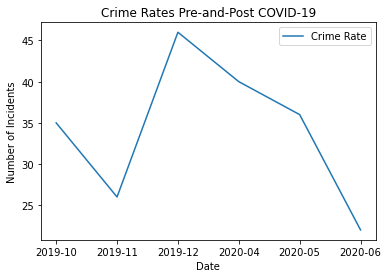

Enter the type of crime data for which to search: outcome_status


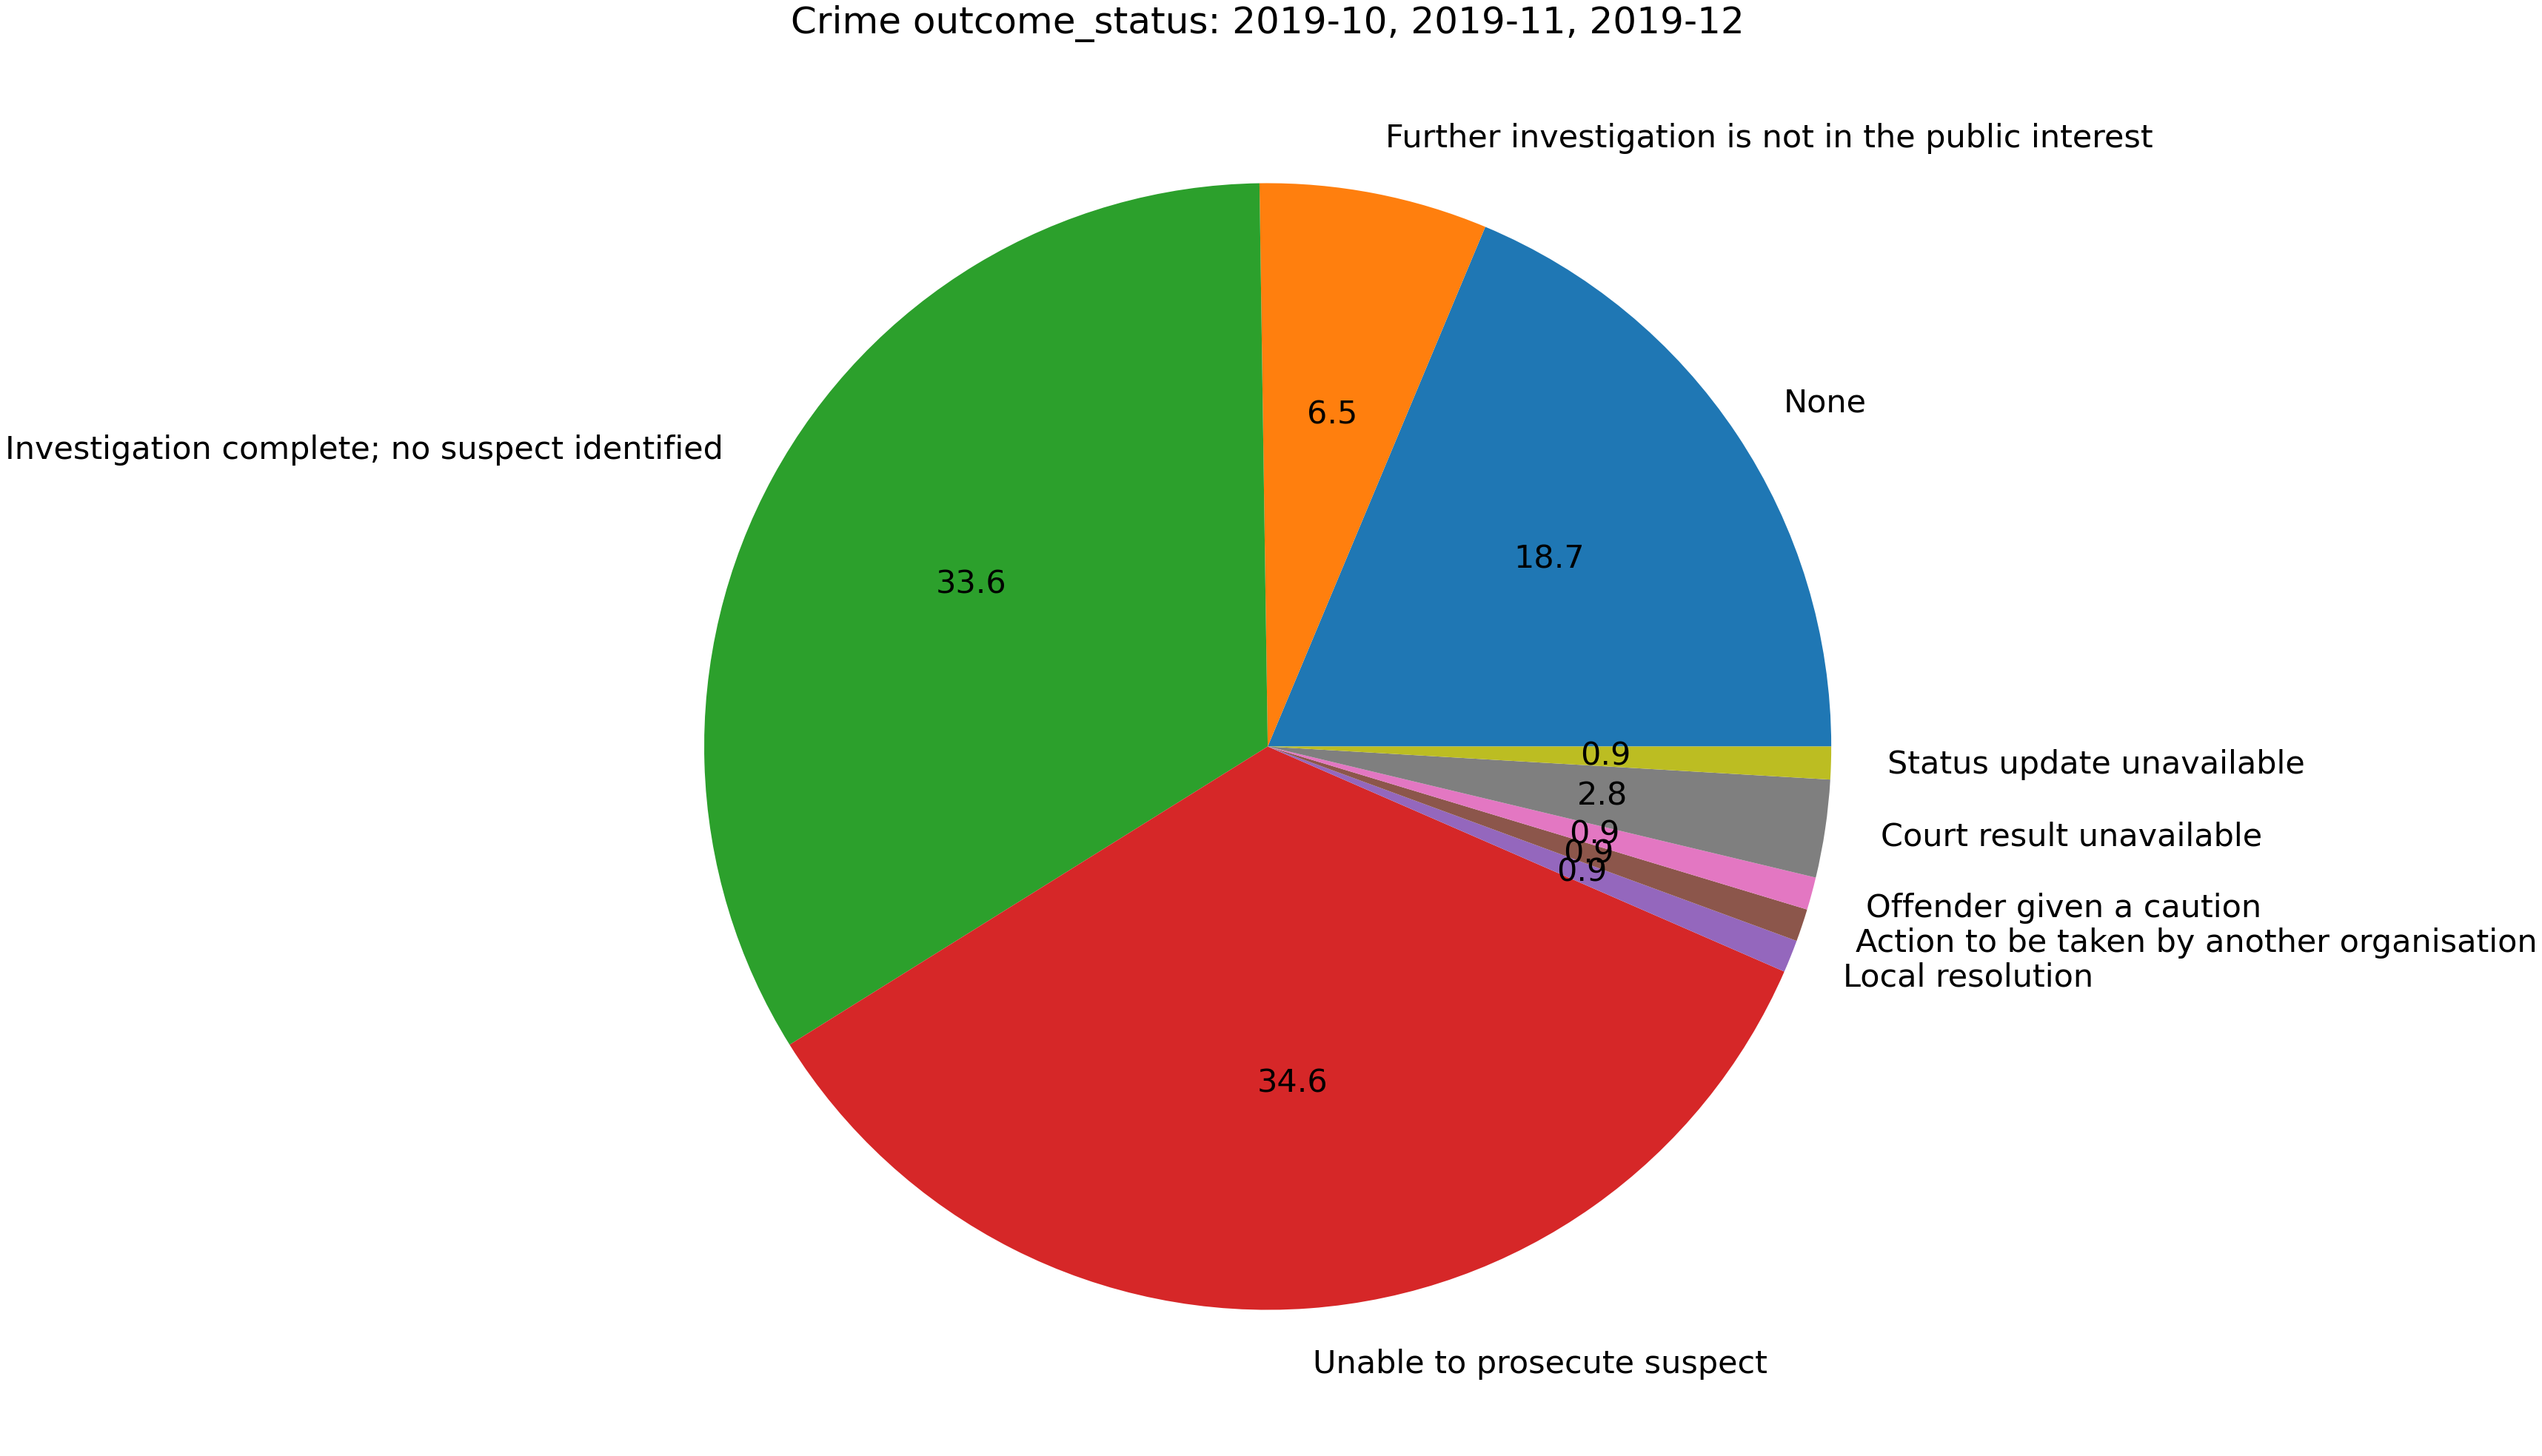

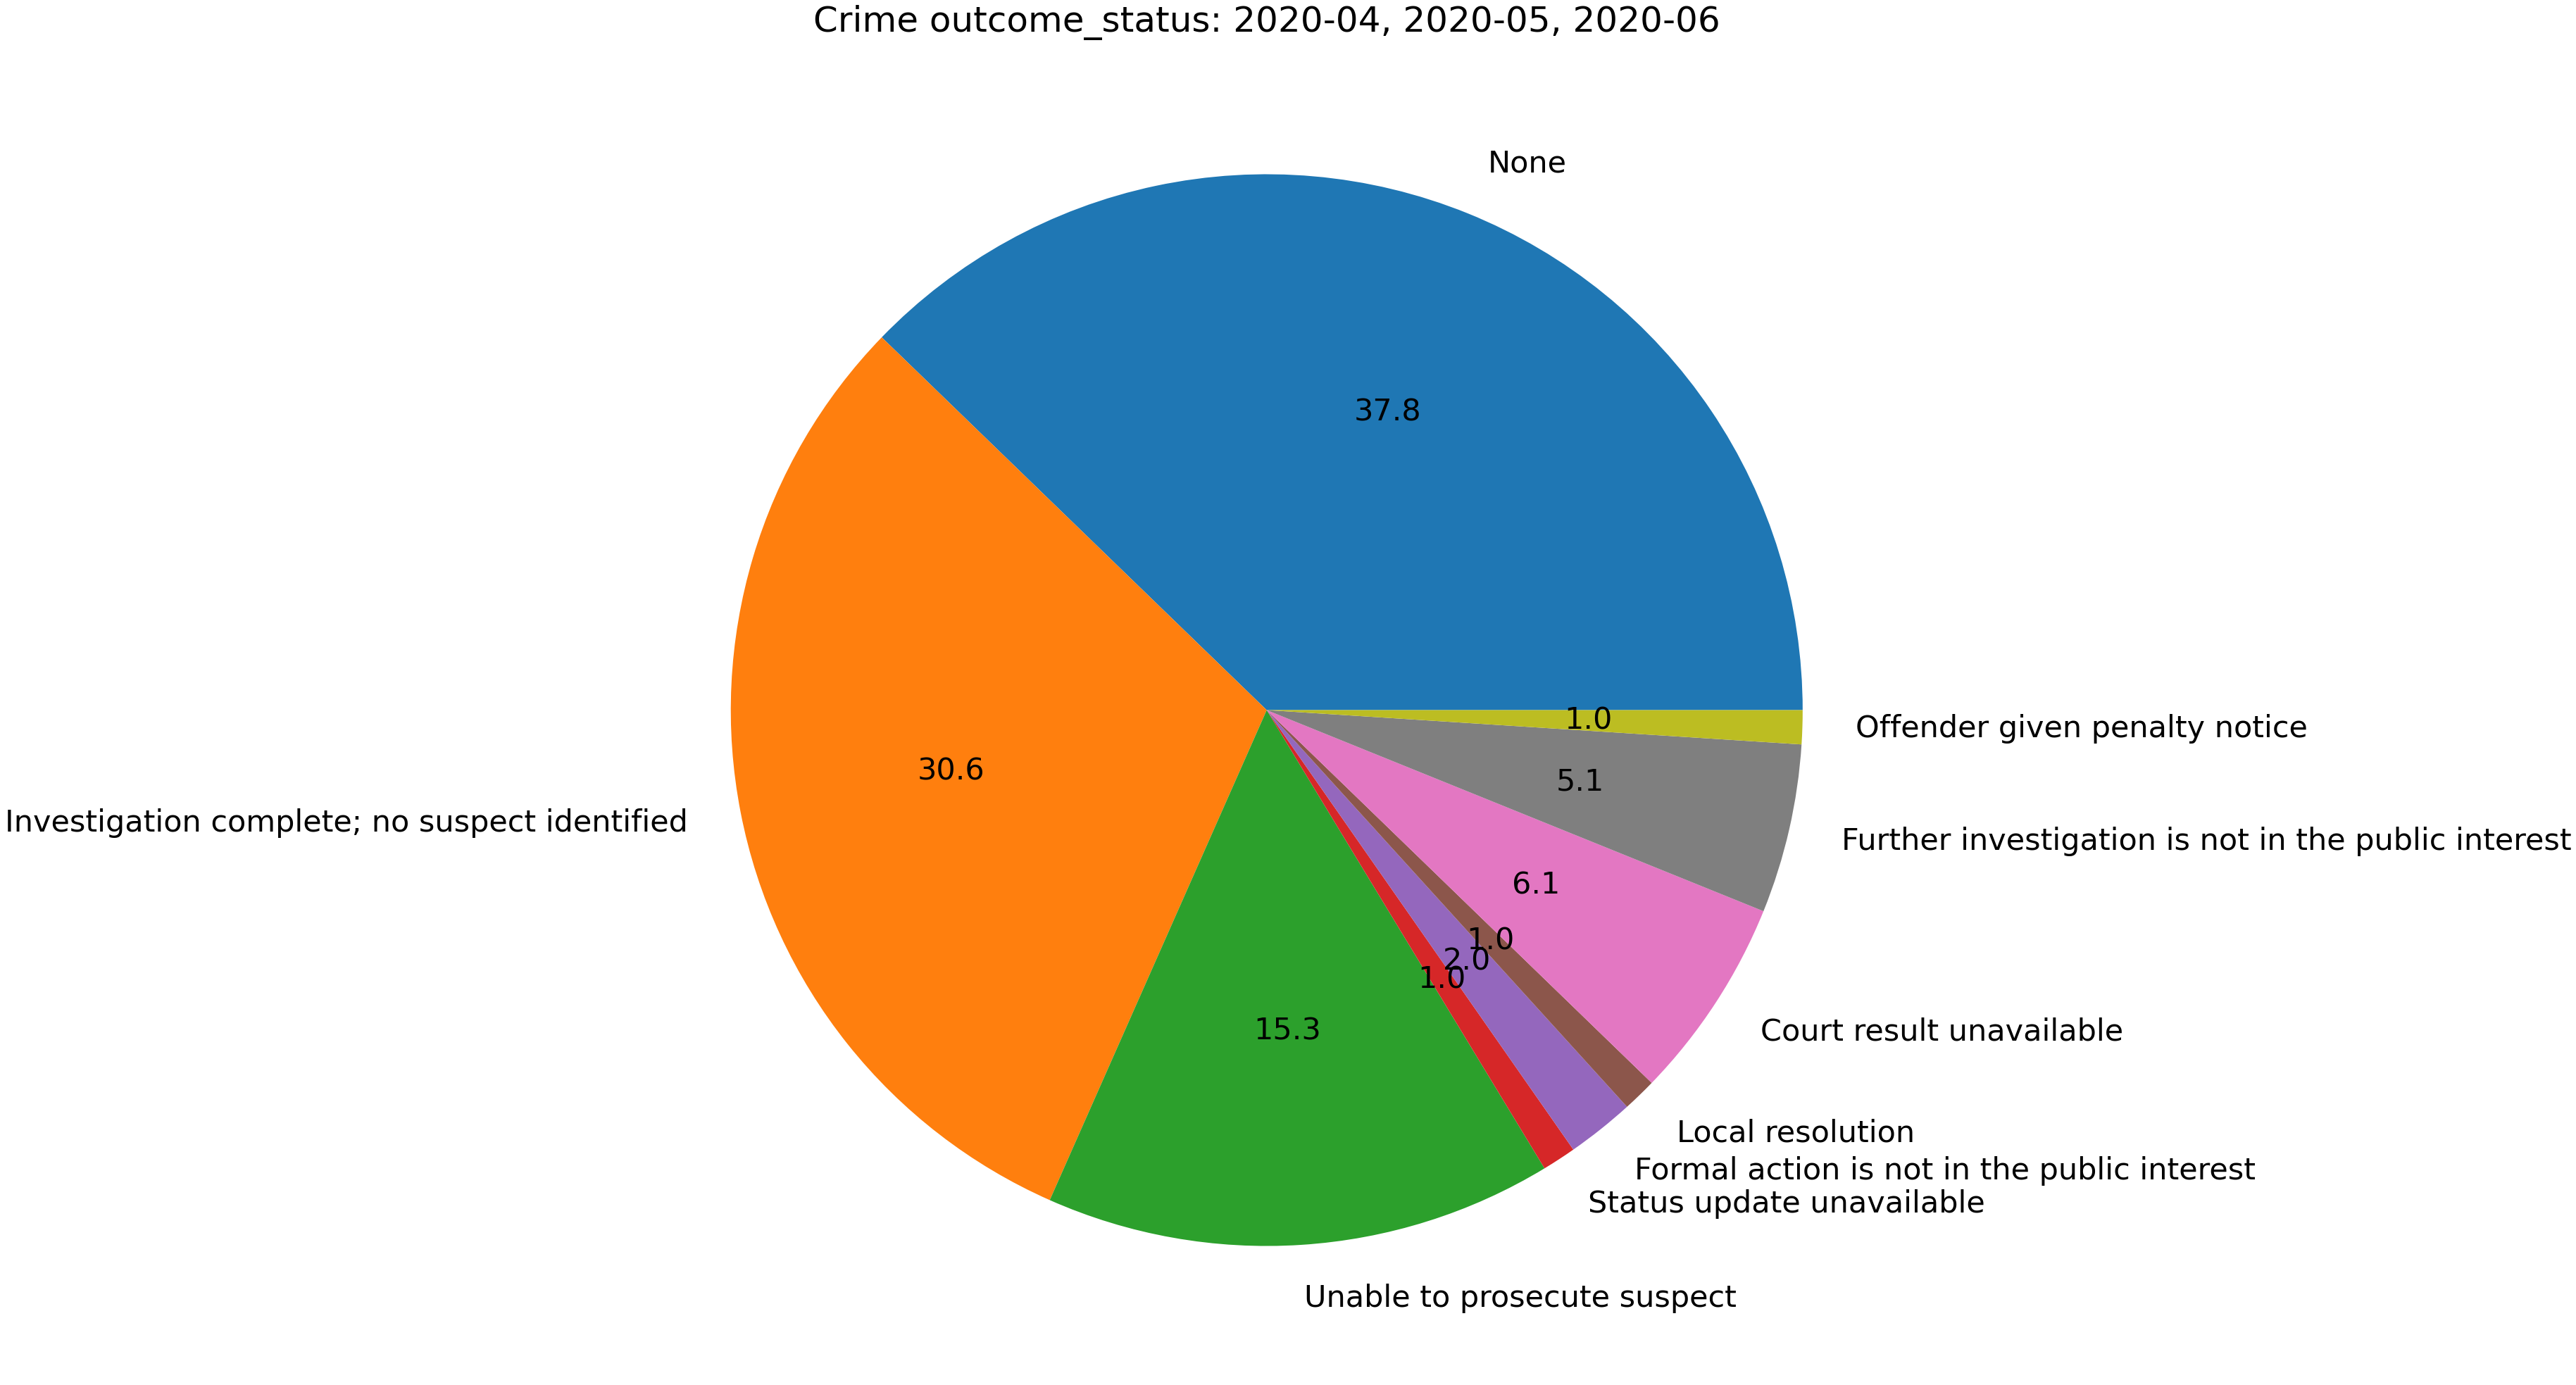

In [30]:
#get neighborhoods for a police for; put into an object
force_nh=choose_force_neighborhood()

#pass neighborhood object to the boundaries function to get the town coordinates 
coordinates=neighborhood_boundaries(force_nh)

#call the API for each desired month, return the data and the date inputs 
js1,js2,js3,js4,js5,js6,ds1,ds2,ds3,ds4,ds5,ds6=monthly_crime(coordinates)

#combine the data into pre and post covid lists 
first3,second3=json_to_list(js1,js2,js3,js4,js5,js6)

#pass chosen dates to analyze crime rates, return dataframe 
full_dataframe=get_crime_rates(ds1,ds2,ds3,ds4,ds5,ds6)

#plot the dataframe 
crime_rates_graph(full_dataframe)

#get user's desired data field (e.g. outcomes, category)
user_search=search_input()

#filter report according to user's search critera for pre-covid data
first3_df=data_search(first3, user_search)

#filter report according to search criteria for post-covid data
second3_df=data_search(second3, user_search )

#pass filtered pre-covid data, search criteria, and dates to be visualized 
analytics_graph(first3_df, user_search, ds1,ds2,ds3)

#pass filtered post-covid data, search criteria, and dates to be visualized 
analytics_graph(second3_df, user_search, ds4,ds5,ds6)

In [31]:
#main()